## 0. Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arcadia_pycolor as apc
from arcadia_pycolor import adjust_lightness
from pathlib import Path
import numpy as np
import scipy.stats as stat

apc.mpl_setup()

## 1. Load Data

In [2]:
output_path = Path('../output/')
combined_data = output_path / 'combined_data.tsv'

combined_data_df = pd.read_csv(combined_data, sep = '\t')
display(combined_data_df)

/var/folders/5b/71_5djmd0p5_yhs0tpbbq68r0000gn/T/ipykernel_19829/3994468543.py:4: DtypeWarning: Columns (0,3,4,5,7,9,10,11,12,14,15,18,19,20,21,23,24,25,26,27,28,29,30,44,45,56,57,58,59,60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_data_df = pd.read_csv(combined_data, sep = '\t')


,protid,UMAP1,UMAP2,StruCluster,LeidenCluster,pdb_origin,pdb_confidence,pdb_chains,TMscore_v_P60709,Entry,...,best_domain_bis,domain_number_exp,domain_number_reg,domain_number_clu,domain_number_ov,domain_number_env,domain_number_dom,domain_number_rep,domain_number_inc,description
0,A0A010QW85,5.711124,-0.868634,SC31,LC10,AlphaFold,69.878344,['A'],0.0,A0A010QW85,...,0.0,1.1,1.0,0.0,0.0,1.0,1.0,1.0,1.0,Actin
1,A0A010RHW1,6.842225,-5.490983,SC39,LC15,AlphaFold,90.340917,['A'],0.0,A0A010RHW1,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,Actin
2,A0A010SEV7,15.114400,-1.790521,SC22,LC21,AlphaFold,88.601931,['A'],0.0,A0A010SEV7,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,Actin
3,A0A015ICG5,-4.460266,13.477738,SC10,LC14,AlphaFold,87.167435,['A'],0.0,A0A015ICG5,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,Actin
4,A0A015J9J4,0.146874,1.547979,SC10,LC14,AlphaFold,87.762448,['A'],0.0,A0A015J9J4,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,Actin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52545,Q8I8C3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,Actin
52546,X6LKS7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,Actin
52547,H7CD47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,Actin
52548,A0A7G5CEI4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,Actin


## 2. Extract relevant columns

In [3]:
list_cols = ['pdb_confidence', 'Length', 'avg_fid', 'lon_fraction_matching', 'lat_fraction_matching', 'atp_fraction_matching', "w_avg_contacts"]

agg_lambda_func = {col: (list if col in list_cols else 'first') for col in combined_data_df.columns }

grouped = combined_data_df.groupby('LeidenCluster').agg(list)

## 3. Define custom functions for plotting

In [4]:
distribution_dict = {}

def sanitize_nested_list(nested_list):
    sanitized_list = []  # Step 1: Initialize an empty list
    for item in nested_list:  # Step 2: Iterate through the given list
        if isinstance(item, list):  # Step 3: Check if the item is a list
            sanitized_sublist = sanitize_nested_list(item)  # Recursive call
            sanitized_list.append(sanitized_sublist)
        elif not pd.isna(item):  # Check if the item is 'NA' or 'na'
            sanitized_list.append(item)  # Append item to the sanitized list
    return sanitized_list  # Step 4: Return the sanitized list

for col in list_cols:
    distribution_dict[col] = dict(grouped[col])
    for item in distribution_dict[col]:
        distribution_dict[col][item] = sanitize_nested_list(distribution_dict[col][item])

def distribution_test(distribution_dict: dict, column: str, data1_keys: list, data2_keys = [], method = 'MWU', *args, **kwargs):
    data_dict = distribution_dict[column]

    data1 = []

    for key in data1_keys:
        data1.extend(data_dict[key])
    
    data2 = []

    if data2_keys == []:
        data2_keys = [key for key in data_dict.keys() if key not in data1_keys]

    for key in data2_keys:
        data2.extend(data_dict[key])

    if method == 'MWU':
        method_fxn = stat.mannwhitneyu
    elif method == 'KS2S':
        method_fxn = stat.ks_2samp
    
    return method_fxn(data1, data2, *args, **kwargs)

## 4. Plot distributions and test statistics

Grey down arrow is significantly different than & median less than LC05; black up arrow is signficantly different and median greater than LC05.
Colored dot is not significantly different to LC05.
Significance threshold is padj < 0.001.


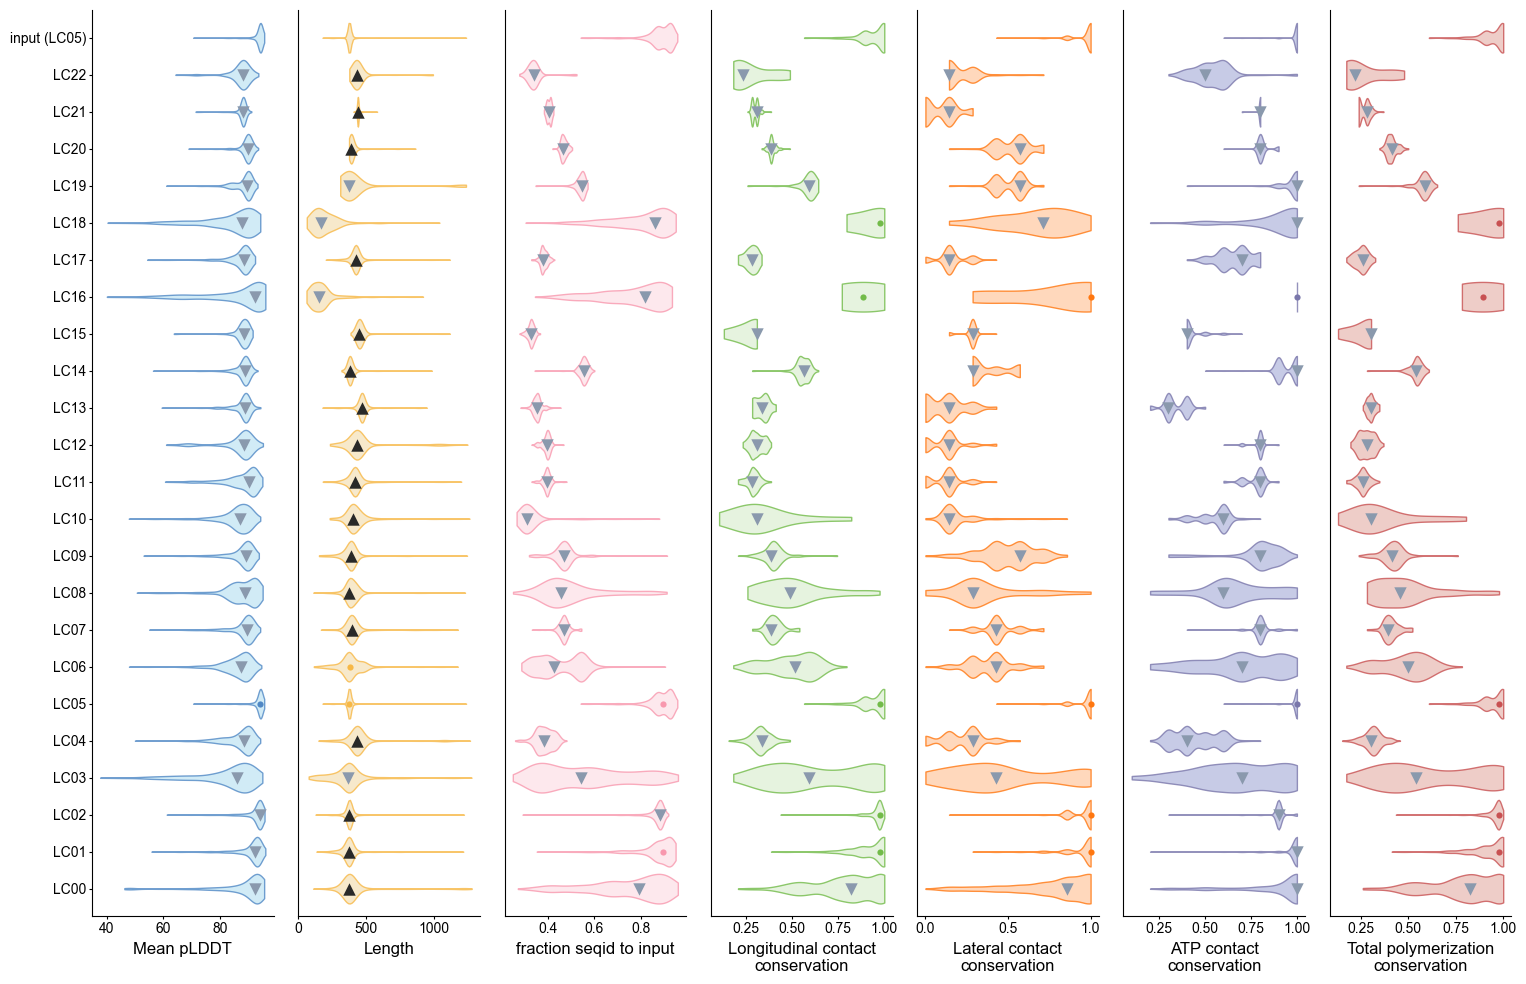

In [31]:
plotting_rules = {
    'Length': {
        'textlabel': 'Length',
        'facecolor': apc.All['arcadia:oat'],
        'edgecolor': apc.All['arcadia:canary']
    },
    'pdb_confidence': {
        'textlabel': 'Mean pLDDT',
        'facecolor': apc.All['arcadia:bluesky'],
        'edgecolor': apc.All['arcadia:aegean']
    }, 
    'avg_fid': {
        'textlabel': 'fraction seqid to input',
        'facecolor': apc.adjust_lightness(apc.All['arcadia:rose'], 1.2),
        'edgecolor': apc.All['arcadia:rose']
    }, 
    'lon_fraction_matching': {
        'textlabel': 'Longitudinal contact\nconservation',
        'facecolor': apc.adjust_lightness(apc.All['arcadia:lime'], 1.4),
        'edgecolor': apc.adjust_lightness(apc.All['arcadia:lime'], 0.8),
    }, 
    'lat_fraction_matching': {
        'textlabel': 'Lateral contact\nconservation',
        'facecolor': apc.adjust_lightness(apc.All['arcadia:tangerine'], 1.1),
        'edgecolor': apc.adjust_lightness(apc.All['arcadia:tangerine'], 0.7)
    }, 
    'atp_fraction_matching': {
        'textlabel': 'ATP contact\nconservation',
        'facecolor': apc.All['arcadia:wish'],
        'edgecolor': apc.All['arcadia:aster']
    },
    "w_avg_contacts": {
        "textlabel": "Total polymerization\nconservation",
        'facecolor': apc.adjust_lightness(apc.All['arcadia:mars'], 1.2),
        'edgecolor': apc.All['arcadia:dragon']
    },
}

#canonical_actin_clus = ["LC00", "LC01", "LC02", "LC05", "LC16"]
canonical_actin_clus = ["LC05"]

stat_results_dict = {}
threshold_pvalue = 0.001

for col in distribution_dict:
    dummy_dict = {}
    for clu in distribution_dict[col]:
        dummy_dict[clu] = distribution_test(distribution_dict, col, [clu], canonical_actin_clus)
    stat_results_dict[col] = dummy_dict

corrected_stat_results_dict = {}

for col in stat_results_dict:
    pvals = [stat_results_dict[col][clu].pvalue for clu in stat_results_dict[col]]
    corrected_pvals = stat.false_discovery_control(pvals)
    corrected_stat_results_dict[col] = {clu: corrected_pvals[i] for i, clu in enumerate(stat_results_dict[col].keys())}

fig, axs = plt.subplots(
    nrows = 1, 
    ncols = len(list_cols), 
    figsize = (2.2 * len(list_cols), 10),
    )

for i, ax in enumerate(axs):
    col = list_cols[i]
    values = list(distribution_dict[col].values())

    canonical_actin_clus_dist = []
    for actin_clu in canonical_actin_clus:
        canonical_actin_clus_dist.extend(distribution_dict[col][actin_clu])
    canonical_actin_clus_median = np.median(canonical_actin_clus_dist)

    values.append(canonical_actin_clus_dist)
    medians_dict = {clu: np.median(values) for clu, values in distribution_dict[col].items()}
    parts = ax.violinplot(values, vert = False, showextrema = False, widths = 0.8)
    for pc in parts['bodies']:
        pc.set_facecolor(plotting_rules[col]['facecolor'])
        pc.set_edgecolor(plotting_rules[col]['edgecolor'])
        pc.set_linewidths(1)
        pc.set_alpha(0.8)
    
    for j, (clu, median) in enumerate(medians_dict.items()):

        if corrected_stat_results_dict[col][clu] > threshold_pvalue:
            marker = "."
            color = plotting_rules[col]['edgecolor']

        elif median < canonical_actin_clus_median:
            marker = "v"
            color = apc.All['arcadia:marineblue']

        elif median > canonical_actin_clus_median:
            marker = "^"
            color = apc.All['arcadia:crow']

        ax.scatter(median, j + 1, marker = marker, color = color, s = 80)

    ax.set_xlabel(plotting_rules[col]['textlabel'])

    if i == 0:
        ax.set_yticks(range(1, len(distribution_dict[col].keys()) + 2) , list(distribution_dict[col].keys()) + ['input (LC05)'])
    else:
        ax.set_yticks([])
    ax.set_ylim((0.25, len(distribution_dict[col].keys()) + 1.75))
    
plt.subplots_adjust(wspace = 0.1)
plt.tight_layout()

plt.savefig("../output/actin_cluster_distributions_vs_LC05.svg", bbox_inches = "tight")
